# Feature Selection
###### Reference: https://scikit-learn.org/stable/modules/feature_selection.html

In [525]:
import pandas as pd
import configparser
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from comet_ml import Experiment
from sklearn import preprocessing
class Directory:
    DATA_DIR = "/Users/raphaelbourque/Desktop/data_science_class/Hockey_primer_2/data/" # Modify the path accordingly
    FIG_DIR = "/Users/raphaelbourque/Desktop/data_science_class/Hockey_primer_2/figures/" # Modify the path accordingly

In [526]:
config = configparser.ConfigParser()
config.read('./configfile.ini')
type_env = 'comet_ml_prod'
COMET_API_KEY = config[type_env]['api_key']
COMET_PROJECT_NAME = config[type_env]['project_name_feature_selection']
COMET_WORKSPACE = config[type_env]['workspace']

comet_exp_obj = Experiment(api_key=COMET_API_KEY,project_name=COMET_PROJECT_NAME,workspace=COMET_WORKSPACE,log_code=True)
comet_exp_obj.set_name(name="Feature Selection")

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/raphaelbourque/Desktop/data_science_class/Hockey_primer_2/notebooks' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.com https://www.comet.com/data-science-workspace/feature-selection/155193119b7c4c10a0e2283f89cd3276



In [527]:
# Load data
X = pd.read_pickle(Directory.DATA_DIR + 'x_train.pkl')
y = pd.read_pickle(Directory.DATA_DIR + 'y_train.pkl')
X.pop('game_id');
X.pop('season');
X.pop('is_goal');

## Important note: we do feature selection using only the train set, to avoid leakage of information from the test set. Some feature selection techniques (embedded and wrapper, specifically) imply both X and y, but are also restricted to the train set for this same reason of avoiding information leakage. In the case of wrapper methods, we use nested k-fold cross-validation *within* the train set. 

## Describe and visualize all variables

In [528]:
X.describe().round(2)

,distance,angle,empty_net,game_period,distance_from_last_event,change_in_shot_angle,speed,x_coordinate,y_coordinate,game_seconds,...,shot_type_Wrist Shot,last_event_type_BLOCKED_SHOT,last_event_type_FACEOFF,last_event_type_GIVEAWAY,last_event_type_GOAL,last_event_type_HIT,last_event_type_MISSED_SHOT,last_event_type_PENALTY,last_event_type_SHOT,last_event_type_TAKEAWAY
count,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,...,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00,252580.00
mean,38.72,-0.87,0.00,2.03,61.95,7.59,8.02,0.05,-0.33,594.17,...,0.53,0.11,0.25,0.10,0.00,0.18,0.10,0.00,0.19,0.07
std,29.68,36.56,0.07,0.84,46.13,20.67,10.17,63.43,19.12,347.62,...,0.50,0.32,0.44,0.29,0.01,0.39,0.29,0.02,0.39,0.25
min,1.00,-165.96,0.00,1.00,0.00,0.00,0.00,-99.00,-42.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,17.89,-28.50,0.00,1.00,26.25,0.00,2.12,-63.00,-15.00,289.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,34.18,0.00,0.00,2.00,46.84,0.00,4.72,-2.00,0.00,586.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,50.57,27.15,0.00,3.00,92.42,0.00,10.08,64.00,14.00,894.00,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,189.65,180.00,1.00,6.00,200.00,209.53,186.63,99.00,42.00,1200.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


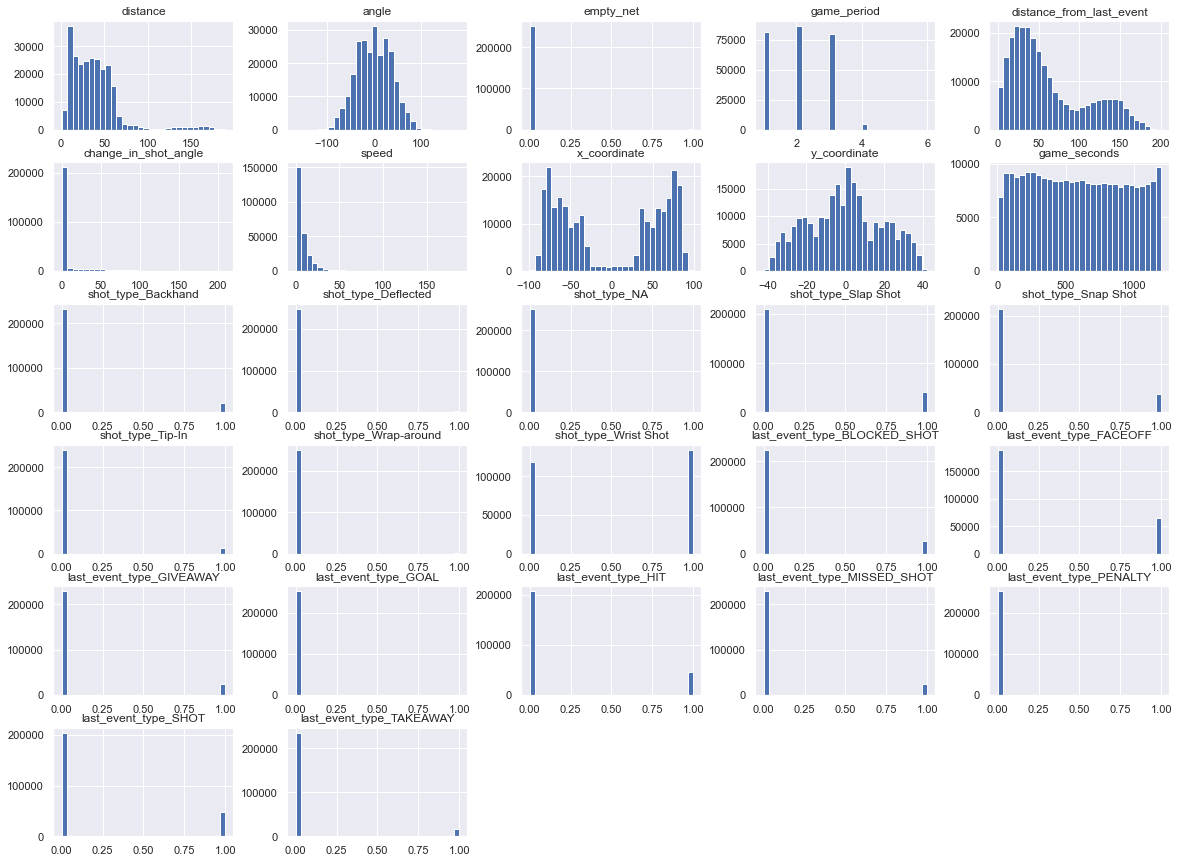

In [529]:
X.hist(bins=30,figsize=(20,15));

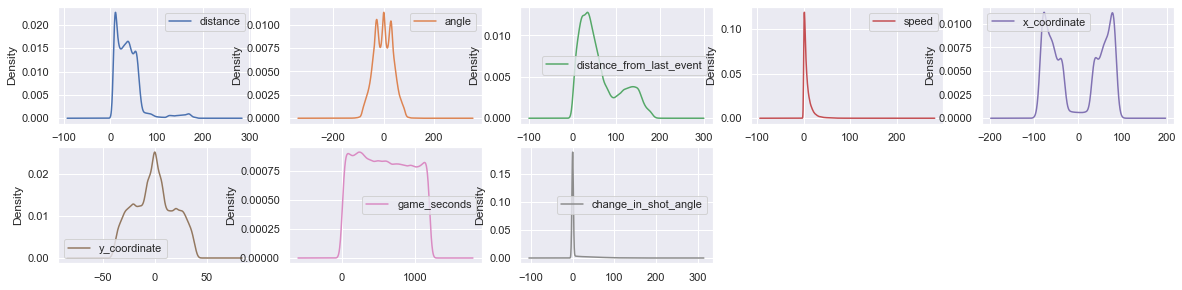

In [530]:
# Here we restrict the density plots to the variables that are truely continuous
X[['distance','angle','distance_from_last_event','speed','x_coordinate','y_coordinate','game_seconds','change_in_shot_angle']].plot(kind='density',subplots=True, layout=(6,5), sharex=False,figsize=(20,15));

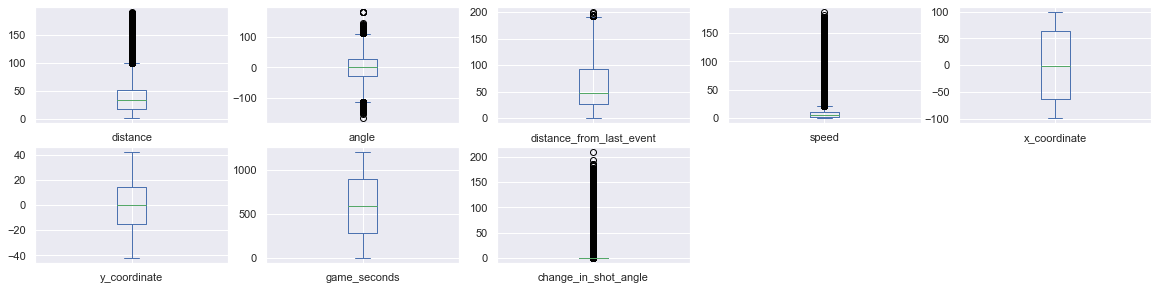

In [531]:
# We also restrict boxplots to continuous variables
X[['distance','angle','distance_from_last_event','speed','x_coordinate','y_coordinate','game_seconds','change_in_shot_angle']].plot(kind='box',subplots=True, layout=(6,5), sharex=False, sharey=False, figsize=(20,15));

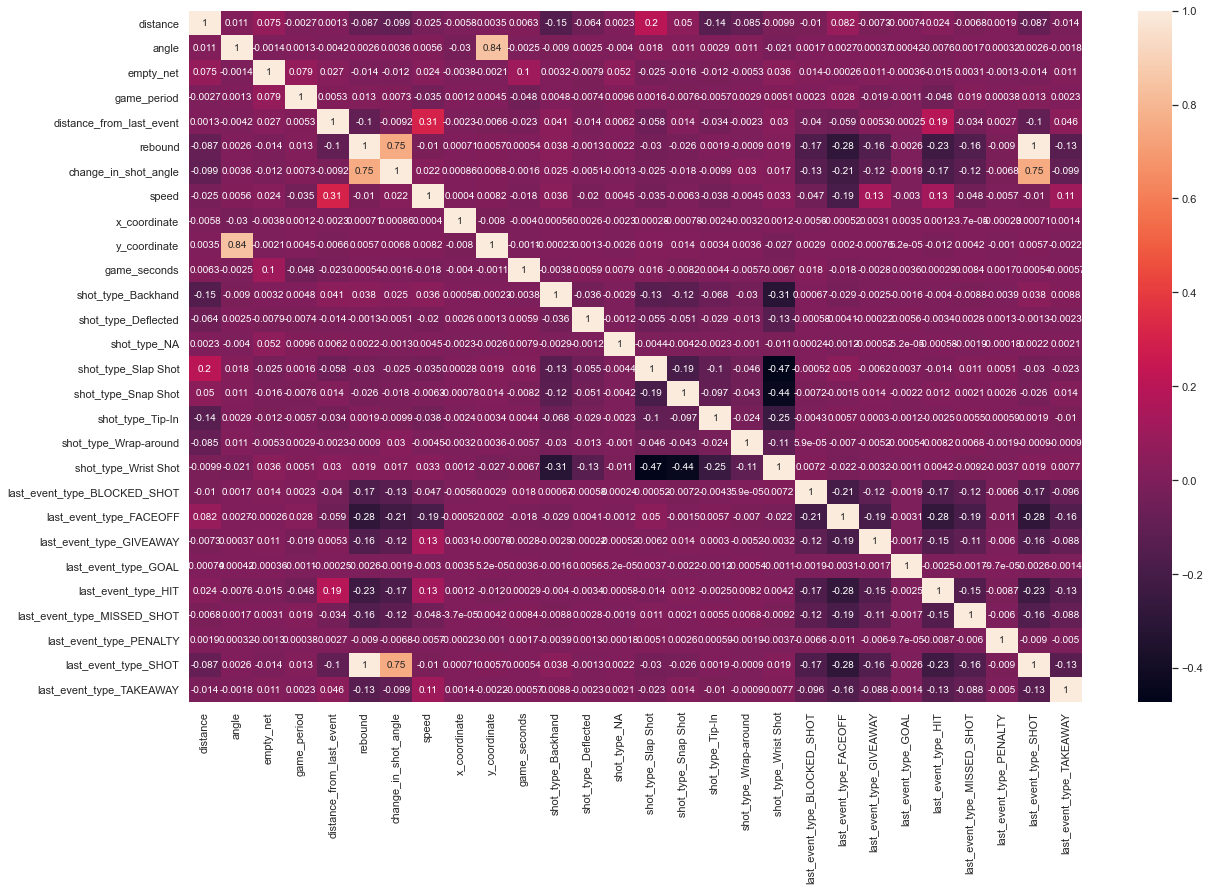

In [532]:
# Correlations among all variables
fig, ax = plt.subplots(figsize=(20, 20));
# sns.set(rc={"figure.figsize":(20, 20)})
ax = sns.heatmap(X.corr(),annot = True);
# Save figure
path = Directory.FIG_DIR + "figure_Heatmap"
fig.subplots_adjust(bottom=0.4)
fig.savefig(path)

In [533]:
comet_exp_obj.log_figure(figure_name="Feature correlation structure", figure=plt,overwrite=False, step=None)
comet_exp_obj.end()

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/data-science-workspace/feature-selection/155193119b7c4c10a0e2283f89cd3276
COMET INFO:   Others:
COMET INFO:     Name : Feature Selection
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_m

<Figure size 432x288 with 0 Axes>

## (A) Filter Methods

In [534]:
# (1) Variance threshold
from sklearn.feature_selection import VarianceThreshold

In [535]:
proportion = 0.8 # threshold to remove all features that are either one or zero in more than this proportion of the sample
t = proportion * (1 - proportion)
sel = VarianceThreshold(threshold=t)
sel.fit_transform(X)
variance = pd.DataFrame(np.log(sel.variances_), index = X.columns, columns=['variance'])

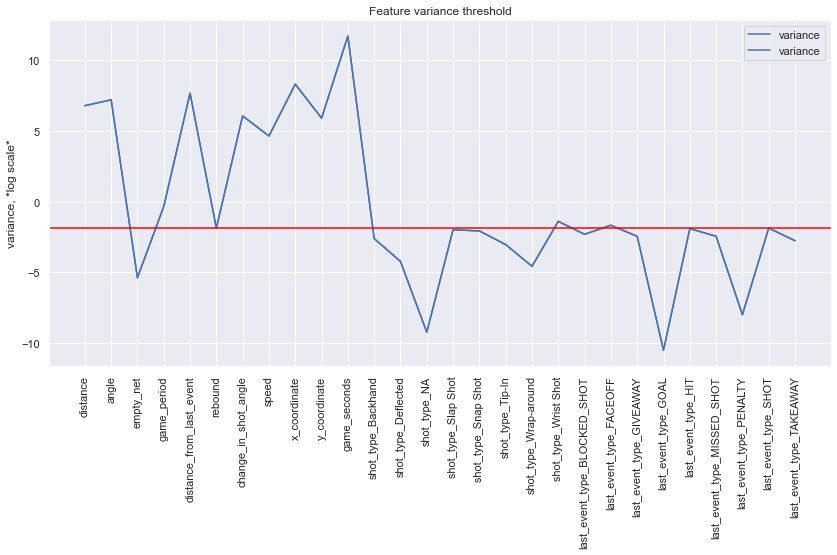

In [536]:
# We plot variance, and the threshold as a red line
fig, ax = plt.subplots(figsize=(14, 10));
ax = sns.lineplot(data=variance);
ax = sns.lineplot(data=variance);
ax.axhline(np.log(t), color='red')
plt.xticks(rotation=90);
ax.set(ylabel='variance, *log scale*')
ax.set(title='Feature variance threshold')
# Save figure
path = Directory.FIG_DIR + "figure_Feature_variance_threshold"
fig.subplots_adjust(bottom=0.4)
fig.savefig(path)

In [568]:
variance_filter = X.columns[pd.Series(sel.variances_).rank(ascending=False)<=5].tolist()
print(variance_filter)

['distance', 'angle', 'distance_from_last_event', 'x_coordinate', 'game_seconds']


In [538]:
comet_exp_obj.log_figure(figure_name="Feature variance and threshold", figure=plt,overwrite=False, step=None)
comet_exp_obj.end()

## For some of the methods that follow, we scale the data, because otherwise methods that use regression do not converge

In [539]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X))
X_scaled.columns = X.columns

In [540]:
# (2) Univariate feature selection
from sklearn import feature_selection

In [541]:
feature_selection_methods = [feature_selection.f_classif, feature_selection.mutual_info_classif,
feature_selection.SelectFpr, feature_selection.SelectFdr, feature_selection.SelectFwe,feature_selection.SelectPercentile]
features = pd.DataFrame(columns = ['model_name'] +  X.columns.values.tolist(), 
index = range(0,len(feature_selection_methods)))

for i, f in enumerate(feature_selection_methods):
    name = f.__name__
    print(name)
    try: 
        scores_list = feature_selection.SelectKBest(f,k='all').fit(X, y).scores_
        scores_list = (scores_list - np.min(scores_list))/np.ptp(scores_list) # Scale between 0 and 1
        scores_list = scores_list.tolist()
        p_values_list = feature_selection.SelectKBest(f,k='all').fit(X, y).pvalues_.tolist()
    except Exception as e: 
        print(e)
        try: 
            scores_list = feature_selection.SelectKBest(f).fit(X, y).scores_
            scores_list = (scores_list - np.min(scores_list))/np.ptp(scores_list) # Scale between 0 and 1
            scores_list = scores_list.tolist()
            p_values_list = feature_selection.SelectKBest(f).fit(X, y).pvalues_.tolist
        except Exception as e: 
            print(e) 
            pass
    
    features.loc[i] = [name] + scores_list

f_classif
mutual_info_classif
'NoneType' object has no attribute 'tolist'
'NoneType' object has no attribute 'tolist'
SelectFpr
__init__() takes from 1 to 2 positional arguments but 3 were given
__init__() takes from 1 to 2 positional arguments but 3 were given
SelectFdr
__init__() takes from 1 to 2 positional arguments but 3 were given
__init__() takes from 1 to 2 positional arguments but 3 were given
SelectFwe
__init__() takes from 1 to 2 positional arguments but 3 were given
__init__() takes from 1 to 2 positional arguments but 3 were given
SelectPercentile
__init__() takes from 1 to 2 positional arguments but 3 were given
__init__() takes from 1 to 2 positional arguments but 3 were given


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


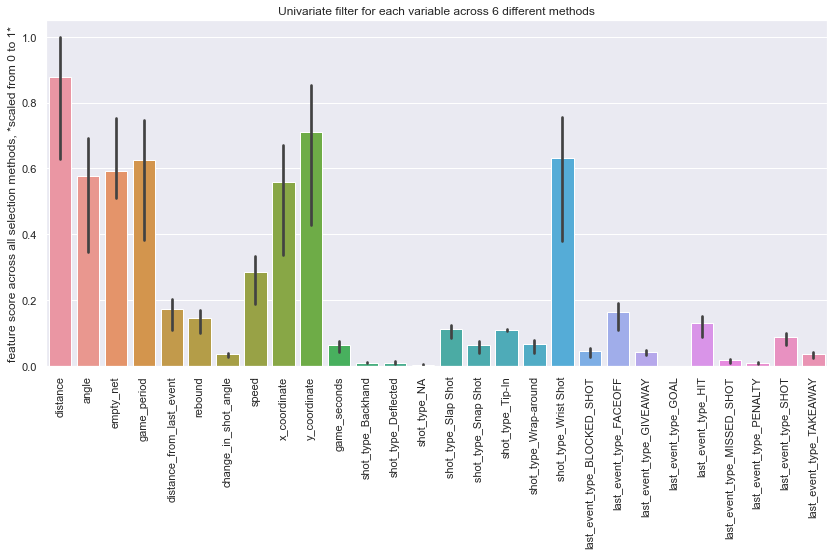

In [542]:
fig, ax = plt.subplots(figsize=(14, 10));
ax = sns.barplot(data=features);
ax.set(ylabel='feature score across all selection methods, *scaled from 0 to 1*')
ax.set(title='Univariate filter for each variable across 6 different methods')
plt.xticks(rotation=90);
# Save figure
path = Directory.FIG_DIR + "figure_Univariate_filter"
fig.subplots_adjust(bottom=0.4)
fig.savefig(path)

In [543]:
univariate_filter = X.columns[features.mean().rank(ascending=False)<=5].tolist()
print(univariate_filter)

['distance', 'empty_net', 'game_period', 'y_coordinate', 'shot_type_Wrist Shot']


/var/folders/9y/r6_mj9t93_jgmpqbq4lw0qd00000gn/T/ipykernel_23871/383042777.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  univariate_filter = X.columns[features.mean().rank(ascending=False)<=5].tolist()


In [544]:
comet_exp_obj.log_figure(figure_name="Univariate filter for each variable across 6 different methods", figure=plt,overwrite=False, step=None)
comet_exp_obj.end()

## (B) Wapper Methods

In [545]:
# Forward search
model = LogisticRegression()
sfs = feature_selection.SequentialFeatureSelector(model, n_features_to_select=5, direction='forward', cv=5)
sfs.fit(X_scaled, y)
logistic_forward_search_wrapper = sfs.get_feature_names_out().tolist()
print(logistic_forward_search_wrapper)

['distance', 'angle', 'empty_net', 'game_period', 'distance_from_last_event']


In [547]:
# Backward search
# model = LogisticRegression()
# sfs = feature_selection.SequentialFeatureSelector(model, n_features_to_select=5, direction='backward', cv=5)
# sfs.fit(X_scaled, y)
# logistic_backward_search_wrapper = sfs.get_feature_names_out().tolist()
# print(logistic_backward_search_wrapper)

## (C) Embedded Methods

In [548]:
# L2-penalized logistic regression 
from sklearn.linear_model import LogisticRegression

In [549]:
logistic_regession_result = feature_selection.SelectFromModel(estimator=LogisticRegression()).fit(X_scaled, y)

In [550]:
embedded_select_from_logistic = X.columns[pd.Series(abs(logistic_regession_result.estimator_.coef_[0])).rank(ascending=False)<=5].tolist()

In [551]:
print(embedded_select_from_logistic)

['distance', 'empty_net', 'distance_from_last_event', 'speed', 'shot_type_Wrap-around']


In [552]:
# SVC
from sklearn.svm import LinearSVC

In [553]:
SVC_regession_result = feature_selection.SelectFromModel(estimator=LinearSVC(C=0.01, penalty="l1", dual=False)).fit(X_scaled, y)

In [554]:
embedded_select_from_SVC = X.columns[pd.Series(abs(SVC_regession_result.estimator_.coef_[0])).rank(ascending=False)<=5].tolist()

In [555]:
print(embedded_select_from_SVC)

['distance', 'empty_net', 'distance_from_last_event', 'speed', 'shot_type_Tip-In']


In [556]:
res = list(zip(abs(logistic_regession_result.estimator_.coef_[0]).tolist(),abs(SVC_regession_result.estimator_.coef_[0]).tolist()))
res = pd.DataFrame(res, index = X.columns, columns=['logistic_regression','linear_SVC'])

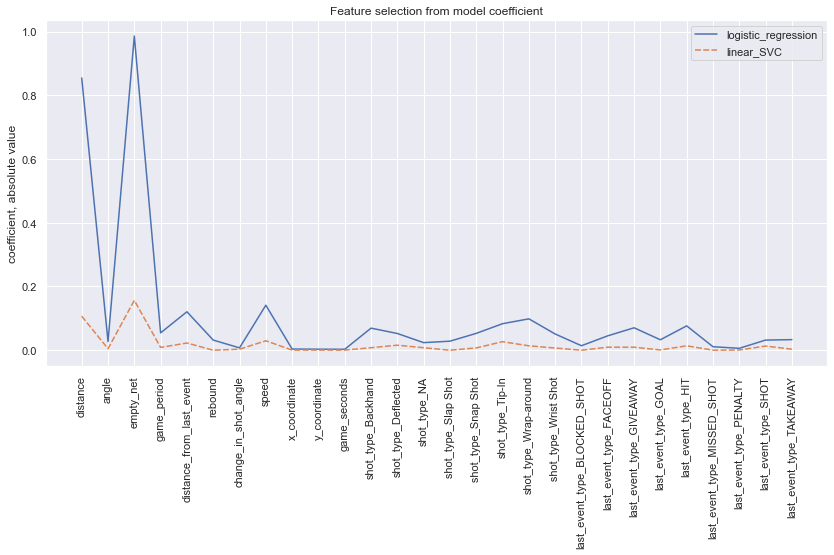

In [557]:
fig, ax = plt.subplots(figsize=(14, 10));
ax = sns.lineplot(data=res);
plt.xticks(rotation=90);
ax.set(ylabel='coefficient, absolute value')
ax.set(title='Feature selection from model coefficient')
fig.subplots_adjust(bottom=0.4)
# Save figure
path = Directory.FIG_DIR + "figure_Feature_selection_from_model_coefficient"
fig.savefig(path)

In [558]:
comet_exp_obj.log_figure(figure_name="Feature selection from model coefficient", figure=plt,overwrite=False, step=None)
comet_exp_obj.end()

In [570]:
A = [variance_filter, univariate_filter, logistic_forward_search_wrapper, embedded_select_from_logistic, embedded_select_from_SVC]

In [571]:
from functools import reduce

In [572]:
print(list(reduce(set.intersection, [set(x) for x in A ])))

['distance']


In [573]:
print(list(reduce(set.union, [set(x) for x in A ])))

['angle', 'distance_from_last_event', 'empty_net', 'shot_type_Wrap-around', 'y_coordinate', 'speed', 'distance', 'x_coordinate', 'game_period', 'shot_type_Tip-In', 'shot_type_Wrist Shot', 'game_seconds']
